# erreur sur charge hydraulique stratifié

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a
# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

In [5]:
print("H riv before")
capteur_riviere.sample(5)

H riv before


,dates,tension,temperature_riviere,dH
1139,2016-07-10 03:30:00,-0.025482,288.948,0.860934
533,2016-07-03 20:00:00,-0.020235,287.558,0.855946
459,2016-07-03 01:30:00,-0.012897,287.257,0.850625
1150,2016-07-10 06:15:00,-0.026106,288.207,0.860615
393,2016-07-02 09:00:00,-0.010786,286.871,0.848792


## Zhan: on peut modifier ici, la charge hydraulique de la rivière données réelles, cste, et perturbation avec le bruit blanc

In [6]:
# import random
## 1. condition limite cste
# capteur_riviere['dH']= np.mean(capteur_riviere['dH'])
## 2. condition limite variation bruite blanche
# elem = np.mean(capteur_riviere['dH'])
# for ele in range(len(capteur_riviere['dH'])):
#     capteur_riviere['dH'][ele] = elem + random.gauss(0, 1e-1)
# print("H riv after")
capteur_riviere.sample(5)

,dates,tension,temperature_riviere,dH
307,2016-07-01 11:30:00,-0.009867,287.775,0.849076
782,2016-07-06 10:15:00,-0.022659,286.228,0.856263
635,2016-07-04 21:30:00,-0.020481,288.649,0.857214
443,2016-07-02 21:30:00,-0.013923,287.797,0.851871
49,2016-06-28 19:00:00,-0.006565,288.769,0.847819


In [7]:
# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [8]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

In [9]:
temps_en_jours = np.array([i for i in range(len(col._times))]) / (4*24)

## 2. Modèle direct

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Colonne homogène

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [10]:
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

Puis on appelle le modèle direct :

In [11]:
col.compute_solve_transi(params, nb_cells=12)

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


### 2.2. Colonne stratifiée

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

## zhan: cas avec $Ss$ cste et deux couche de perméabilité différente

In [12]:
layers_list = layersListCreator([("Couche 1", 0.20, 5, 0.1, 2, 4e6), ("Couche 2", 0.40, 7, 0.1, 2, 4e6)])
# layers_list = layersListCreator([("Couche 1", 0.10, 4, 0.1, 2, 4e6), ("Couche 2", 0.20, 6, 0.1, 2, 4e6), ("Couche 3", 0.30, 7, 0.1, 2, 4e6), ("Couche 4", 0.40, 8, 0.1, 2, 4e6)])

Puis on appelle le modèle direct :

## zhan: réalisation de l'équation de diffusivité

In [13]:
dH_measures = np.array([d for _, (d, _) in dH_measures])
print("condition aux limites de la rivière")
print(dH_measures)
print(len(dH_measures))

condition aux limites de la rivière
[0.84556517 0.84559872 0.84563867 ... 0.86422199 0.86423169 0.86416241]
1309


In [14]:
# H_init_pyheatmy = self._dH[0] - self._dH[0] * self._z_solve / self._real_z[-1]

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


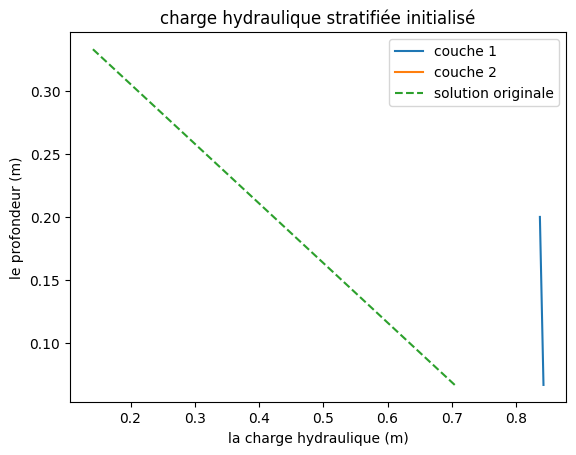

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=5, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=7, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [0.84556517 0.83719324 0.        ]
conditions aux limites
H_riv [0.84277453 0.84277453 0.84277453 ... 0.84277453 0.84277453 0.84277453]
H_aq [0. 0. 0. ... 0. 0. 0.]


/opt/homebrew/lib/python3.11/site-packages/numba/core/ir_utils.py:2174: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'list_zLow' of function 'compute_H_stratified'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "utils.py", line 400:
@njit
def compute_H_stratified(list_zLow, z_solve, moinslog10K_list, Ss_list, all_dt, isdtconstant, dz, H_init, H_riv, H_aq, alpha=ALPHA):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


zhan list_zLow [0.2]
zhan ncell 3
carateristique of interface:
0.2 interface symetric with index 1


/Users/jingzhan/Documents/GitHub/MOLONARI1D/pyheatmy2022/pyheatmy/core.py:321: RuntimeWarning: invalid value encountered in subtract
  nablaH[i, :] = (H_res[i+1, :] - H_res[i, :]) / dz
/Users/jingzhan/Documents/GitHub/MOLONARI1D/pyheatmy2022/pyheatmy/core.py:321: RuntimeWarning: overflow encountered in divide
  nablaH[i, :] = (H_res[i+1, :] - H_res[i, :]) / dz


Done.
zhan z_solve [0.06666667 0.2        0.33333333]


In [15]:
col.compute_solve_transi(layers_list, nb_cells=3)
print("zhan z_solve", col._z_solve)

### zhan: voyons que le charge hydraulique initialisé en suivant la loi de conservation de flux sur chaque d'interface est comme ci-dessus, maintenant nous étudions son évaluation avec le temps

[0.06666667 0.2        0.33333333]


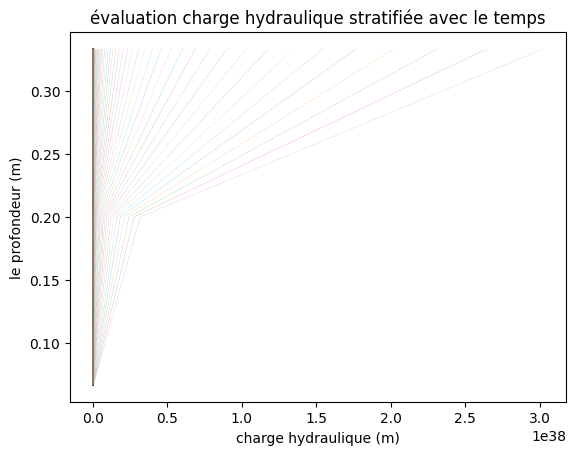

In [16]:
print(col._z_solve)
for idx in range(1309):
    plt.plot(col._H_res[:,idx], col._z_solve, label = str(idx * 15) + 'min', linewidth = 0.1)
plt.title('évaluation charge hydraulique stratifiée avec le temps')
plt.xlabel('charge hydraulique (m)')
plt.ylabel('le profondeur (m)')
plt.show()

### étudions la perméabilité sur l'interface

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


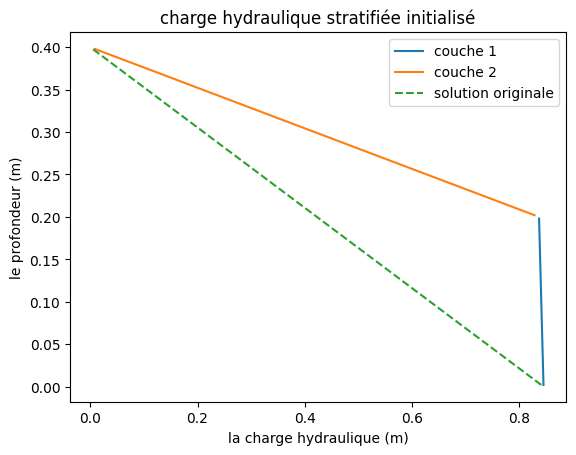

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=5, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=7, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [0.84556517 0.83719324 0.        ]
conditions aux limites
H_riv [0.84548145 0.84548145 0.84548145 ... 0.84548145 0.84548145 0.84548145]
H_aq [0. 0. 0. ... 0. 0. 0.]
zhan list_zLow [0.2]
zhan ncell 100
carateristique of interface:
0.2 interface asymetric with neighbour index (49, 50)
Done.
zhan z_solve [0.002 0.006 0.01  0.014 0.018 0.022 0.026 0.03  0.034 0.038 0.042 0.046
 0.05  0.054 0.058 0.062 0.066 0.07  0.074 0.078 0.082 0.086 0.09  0.094
 0.098 0.102 0.106 0.11  0.114 0.118 0.122 0.126 0.13  0.134 0.138 0.142
 0.146 0.15  0.154 0.158 0.162 0.166 0.17  0.174 0.178 0.182 0.186 0.19
 0.194 0.198 0.202 0.206 0.21  0.214 0.218 0.222 0.226 0.23  0.234 0.238
 0.242 0.246 0.25  0.254 0.258 0.262 0.266 0.27  0.274 0.278 0.282 0.286
 0.29  0.294 0.298 0.302 0.306 0.31  0.314 0

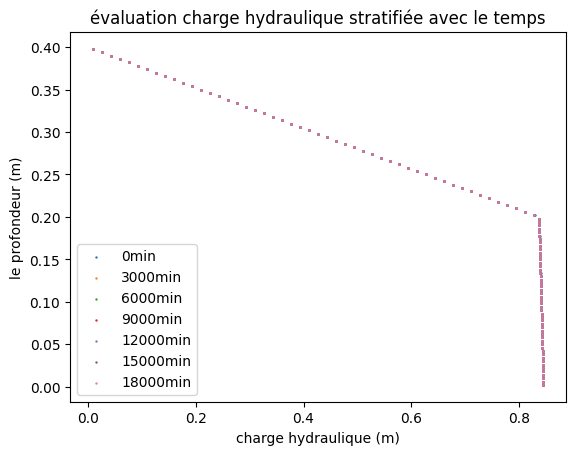

In [17]:
col.compute_solve_transi(layers_list, nb_cells=100)
print("zhan z_solve", col._z_solve)
print(col._z_solve)
for idx in range(0, 1309, 200):
    plt.scatter(col._H_res[:,idx], col._z_solve, label = str(idx * 15) + 'min', s = 0.5)
plt.legend()
plt.title('évaluation charge hydraulique stratifiée avec le temps')
plt.xlabel('charge hydraulique (m)')
plt.ylabel('le profondeur (m)')
plt.show()

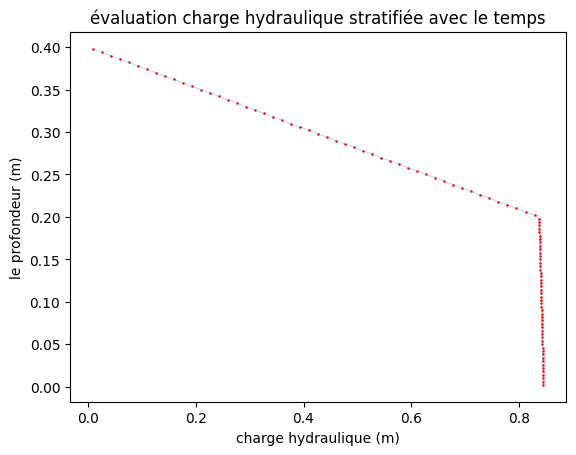

In [24]:
plt.plot(col._H_res[:,idx], col._z_solve, linewidth = 0.2)
plt.scatter(col._H_res[:,idx], col._z_solve, s = 0.7, c = 'r')
plt.title('évaluation charge hydraulique stratifiée avec le temps')
plt.xlabel('charge hydraulique (m)')
plt.ylabel('le profondeur (m)')
plt.show()

In [19]:
import sympy as sp

# 定义符号变量
K1, K2, h1, h2 = sp.symbols('K1 K2 h1 h2', positive=True)
Um, Up = sp.symbols('Um, Up')

# 定义符号矩阵
A = sp.Matrix([[0, K1, -K2], [1, -h1, 0], [1, 0, h2]])

# 计算逆矩阵
A_inv = A.inv()

# 打印逆矩阵
A_inv
sp.Matrix([0, Um, Up])
A_inv * sp.Matrix([0, Um, Up])

Matrix([
[K1*Um*h2/(K1*h2 + K2*h1) + K2*Up*h1/(K1*h2 + K2*h1)],
[     -K2*Um/(K1*h2 + K2*h1) + K2*Up/(K1*h2 + K2*h1)],
[     -K1*Um/(K1*h2 + K2*h1) + K1*Up/(K1*h2 + K2*h1)]])